<a href="https://colab.research.google.com/github/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/CPR_prediction_multivariate_LSTM_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Standard Imports for RNNs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

In [2]:
url = "https://github.com/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/excel_dataset.xlsx?raw=true"
df = pd.read_excel(url)
#df = df[5::6] #Hour-wise Data
df.head()

,Date Time,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH
0,01.01.2009 00:10:00,0.428151,18.960609,3.973630,29.732470,0.014431,30711.65039,820.118210,632.399261,0.466357,1.444160,-5.616851,75.809700
1,01.01.2009 00:20:00,0.427783,18.960360,3.973562,30.123590,0.014822,30700.66016,819.662811,633.057602,0.475288,1.413894,-5.540349,75.810066
2,01.01.2009 00:30:00,0.427432,19.009649,4.181924,30.477831,0.012689,30689.66016,819.886444,631.841385,0.464559,1.515123,-5.628389,75.552841
3,01.01.2009 00:40:00,0.427082,19.155710,3.950392,30.425819,0.012580,30678.66016,819.660172,632.495224,0.471809,1.404055,-5.576591,75.580223
4,01.01.2009 00:50:00,0.426732,19.334640,3.689848,30.546061,0.012472,30667.66016,819.646805,632.388214,0.470504,1.191485,-5.274679,75.638023


In [3]:
#Separating Date and Time
#To be used in plotting in X-axis
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S') #pop command takes the Date Time Column out of df, so df no longer has that column.

We need to remove $Ethylene$ and $AI12201M$ columns as they are not controllable factors. 

In [4]:
df = df.drop('ETHYLENE',axis=1)
df = df.drop('AI12201M',axis=1)
df.head()

,CPRAVG,PROP,BUT,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH
0,0.428151,18.960609,3.973630,30711.65039,820.118210,632.399261,0.466357,1.444160,-5.616851,75.809700
1,0.427783,18.960360,3.973562,30700.66016,819.662811,633.057602,0.475288,1.413894,-5.540349,75.810066
2,0.427432,19.009649,4.181924,30689.66016,819.886444,631.841385,0.464559,1.515123,-5.628389,75.552841
3,0.427082,19.155710,3.950392,30678.66016,819.660172,632.495224,0.471809,1.404055,-5.576591,75.580223
4,0.426732,19.334640,3.689848,30667.66016,819.646805,632.388214,0.470504,1.191485,-5.274679,75.638023


In [5]:
#Variables for training
cols = list(df)[0:df.shape[1]]
#To enforce that values in these columns are actually float type data
df_for_rnn = df[cols].astype(float)

In [6]:
#Creating training_df and test_df
n = len(df)
training_df = df_for_rnn[0:int(n*0.7)]
test_set = df_for_rnn[int(n*0.7):n]

In [7]:
#Scaling the Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0,1))
df_for_training_scaled = scaler.fit_transform(training_df) #Scales and converts to numpy object
print('Scaled Dataset:\n',df_for_training_scaled)

Scaled Dataset:
 [[0.04261512 0.39141737 0.71843606 ... 0.54553167 0.061713   0.69995722]
 [0.03834461 0.39139343 0.71841953 ... 0.53416085 0.09054363 0.69998058]
 [0.03428528 0.39611563 0.76908826 ... 0.57219227 0.05736476 0.68357295]
 ...
 [0.94817084 0.28810413 0.68416253 ... 0.67555781 0.51802072 0.79587724]
 [0.95048011 0.28807252 0.68538325 ... 0.68702255 0.51584291 0.79587529]
 [0.95188739 0.28809554 0.70426883 ... 0.68955967 0.51498322 0.79587237]]


In [8]:
#Readying the Multivariate Input and Univariate Output

#initialisation
trainX = [] 
trainY = []

n_future = 1 #number of hours into the future
n_past = 60  #number of hours into the past

for i in range(n_past, len(df_for_training_scaled)-n_future+1):
  trainX.append(df_for_training_scaled[i-60:i,:])
  trainY.append(df_for_training_scaled[i+n_future-1:i+n_future,0])
trainX = np.array(trainX)   # shape 1: no of records, shape 2: past_days, shape 3: input_cols
trainY = np.array(trainY)   # shape 1: records, shape 2: future prediction data
print('TrainX shape = (%d,%d,%d)'%(trainX.shape[0],trainX.shape[1],trainX.shape[2]))
print('TrainY shape = (%d,%d)'%(trainY.shape[0],trainY.shape[1]))

TrainX shape = (8667,60,10)
TrainY shape = (8667,1)


In [9]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64,activation='sigmoid',return_sequences=True,input_shape = (trainX.shape[1],trainX.shape[2])))
model.add(LSTM(32,activation='sigmoid',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam',loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            19200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Let's traaaaaaaaaaaainnn

history = model.fit(trainX,trainY,epochs=100,verbose=1,batch_size=32,validation_split=0.1)

Epoch 1/100
244/244 [==============================] - 44s 65ms/step - loss: 0.1034 - val_loss: 0.0401
Epoch 2/100
244/244 [==============================] - 15s 61ms/step - loss: 0.0304 - val_loss: 0.0088
Epoch 3/100
244/244 [==============================] - 15s 60ms/step - loss: 0.0132 - val_loss: 0.0079
Epoch 4/100
244/244 [==============================] - 15s 62ms/step - loss: 0.0104 - val_loss: 0.0076
Epoch 5/100
244/244 [==============================] - 16s 65ms/step - loss: 0.0088 - val_loss: 0.0037
Epoch 6/100
244/244 [==============================] - 15s 61ms/step - loss: 0.0078 - val_loss: 0.0100
Epoch 7/100
244/244 [==============================] - 14s 58ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 8/100
244/244 [==============================] - 14s 59ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 9/100
244/244 [==============================] - 14s 59ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 10/100
244/244 [==============================] - 14s 59ms/step - l

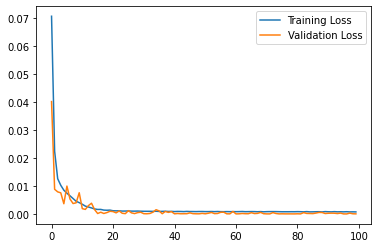

In [11]:
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()

In [12]:
test_df_scaled = scaler.transform(test_set)
testX = []
for i in range(n_past,len(test_df_scaled)+n_future-1):
  testX.append(test_df_scaled[i-n_past:i,:])
testX = np.array(testX)
testX.shape

(3681, 60, 10)

[[0.5077677 ]
 [0.5075775 ]
 [0.50748295]
 ...
 [0.51618093]
 [0.51614034]
 [0.5159124 ]]


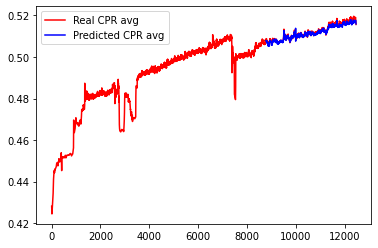

In [13]:
predicted_CPRAVG = model.predict(testX)
predicted_CPRAVG = np.repeat(predicted_CPRAVG,test_df_scaled.shape[1],axis = -1)
predicted_CPRAVG = scaler.inverse_transform(predicted_CPRAVG)[:,0]
predicted_CPRAVG = predicted_CPRAVG.reshape(-1,1)
print(predicted_CPRAVG)
predicted_CPRAVGplot = np.empty_like(df)
predicted_CPRAVGplot[:,:] = np.nan
predicted_CPRAVGplot[training_df.shape[0]+n_past:df.shape[0],:] = predicted_CPRAVG
plt.plot(df['CPRAVG'],color = 'red', label = 'Real CPR avg')
plt.plot(predicted_CPRAVGplot[:,0], color = 'blue', label = 'Predicted CPR avg')
plt.legend()

Time to predict the future!

We shall use the previous $200$ data predict $CPRAVG$.


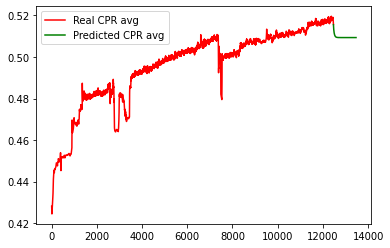

In [18]:
starting_record = df.shape[0]
CPRAVG_real_values = df['CPRAVG']
temp = df
for i in range(1000):
  #Gathering the previous 200 data
  total_df_length = temp.shape[0]
  future_Xinput = temp[total_df_length - 60:total_df_length]
  future_Xinput_scaled = scaler.transform(future_Xinput)
  future_Xinput_scaled_batch = np.array([future_Xinput_scaled])
  future_prediction = model.predict(future_Xinput_scaled_batch)
  future_prediction = np.repeat(future_prediction, future_Xinput_scaled.shape[1],axis = -1)
  future_prediction = scaler.inverse_transform(future_prediction)[:,0]

  #Parameters to be set:
  future_data = {}
  future_data.update(CPRAVG = future_prediction[0])
  future_data.update(PROP = df['PROP'][starting_record-1], BUT = df['BUT'][starting_record-1], FLW = df['FLW'][starting_record-1],	COT = df['COT'][starting_record-1],	TEMP = df['TEMP'][starting_record-1],	PRESS = df['PRESS'][starting_record-1],	O2 = df['O2'][starting_record-1],	DRAFT = df['DRAFT'][starting_record-1], ETH = df['ETH'][starting_record-1])
  future_data = pd.DataFrame.from_dict(future_data, orient='index').T
  temp = temp.append(future_data, ignore_index=True)
future_df = temp[starting_record:temp.shape[0]]
CPRAVG_predicted_values = future_df['CPRAVG']
plt.plot(CPRAVG_real_values,color = 'red', label = 'Real CPR avg')
plt.plot(CPRAVG_predicted_values, color = 'green', label = 'Predicted CPR avg')
plt.legend()

In [15]:
pd.set_option('display.max_rows', None)  # or 1000
print(future_df)

         CPRAVG  PROP  BUT      FLW    COT   TEMP  PRESS    O2  DRAFT   ETH
12468  0.515462  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12469  0.515190  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12470  0.514920  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12471  0.514666  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12472  0.514427  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12473  0.514202  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12474  0.513989  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12475  0.513787  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12476  0.513595  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12477  0.513412  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12478  0.513238  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12479  0.513071  23.0  4.0  28620.0  850.0  655.0   0.49  0.99  -4.95  71.5
12480  0.512